In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import KBinsDiscretizer

In [ ]:
seq_length = 4
d_model = 16
nhead = 4
num_layers = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

shuffle = True

batch_size = 32

In [ ]:
# Define your stock and data parameters
stock = '^GSPC'

def get_stock(stock_choice):
    start, end = '', ''
    if stock_choice == '^GSPC':
        start = '1980-01-01'
        end = '2024-08-10'
    elif stock_choice == 'AAPL':
        start = '1984-12-12'
        end = '2024-08-10'
    elif stock_choice == '^DJI':
        start = '1980-01-01'
        end = '2024-08-10'
    elif stock_choice == 'PFE':
        start = '1980-01-01'
        end = '2024-08-10'
    elif stock_choice == 'GOOGL':
        start = '2004-08-19'
        end = '2024-08-10'
    elif stock_choice == 'TSLA':
        start = '2010-06-29'
        end = '2024-08-10'
    else:
        start = '2010-01-01'
        end = '2024-08-10'

    return start, end

start, end = get_stock(stock)

# Download stock data
yfd = yf.download(stock, start=start, end=end)

# Calculate percent change for closing price
yfd['Percent_Change'] = yfd['Close'].pct_change()

# Select features to include: Percent Change and Volume
features = ['Percent_Change', 'Volume']
df = yfd[features].dropna()

# Normalize the data
std = df.std()
mean = df.mean()

normalized_data = (df - mean) / std

print(normalized_data.head())

# Create sequences
sequences = []
for i in range(len(normalized_data) - seq_length):
    sequences.append(normalized_data[i:i + seq_length].values)

sequences = np.array(sequences)

# Prepare the X and y datasets
X = []
y = []

for i in range(len(normalized_data) - seq_length - 1):
    X.append(normalized_data.iloc[i:i + seq_length].values)

X = np.array(X).reshape((len(X), seq_length, len(features)))

# Calculate the 33rd and 66th percentiles to split the data into three equal parts
quantiles = np.percentile(df['Percent_Change'], [33, 66])

# Define the bin edges based on these quantiles
bins = [-np.inf, quantiles[0], quantiles[1], np.inf]

# Ensure num_bins reflects the number of bins created
num_bins = len(bins) - 1

# Digitize the y values into bins
y_binned = np.digitize(df['Percent_Change'], bins) - 1  # -1 to make it 0-indexed

# Replace the original 'y' array with binned values
y = []
for i in range(len(normalized_data) - seq_length - 1):
    y.append(y_binned[i + seq_length])

y = np.array(y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Create original indices
original_indices = np.arange(len(X_tensor))

# Split data
x_train, x_temp, y_train, y_temp, train_indices, temp_indices = train_test_split(
    X_tensor, y_tensor, original_indices, test_size=0.3, random_state=42, shuffle=True)

x_val, x_test, y_val, y_test, val_indices, test_indices = train_test_split(
    x_temp, y_temp, temp_indices, test_size=0.5, random_state=42, shuffle=False)

# Create TensorDatasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create DataLoaders
batch_size = 32  # Adjust this as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

[*********************100%***********************]  1 of 1 completed


            Percent_Change    Volume
Date                                
1980-01-03       -0.490185 -0.998482
1980-01-04        1.060777 -1.004442
1980-01-07        0.205171 -1.001622
1980-01-08        1.743000 -0.996953
1980-01-09        0.044879 -0.990719


In [ ]:
# Check the distribution of data points across bins
unique, counts = np.unique(y_binned, return_counts=True)
print("Bin distribution:", dict(zip(unique, counts)))


Bin distribution: {0: 3711, 1: 3711, 2: 3823}


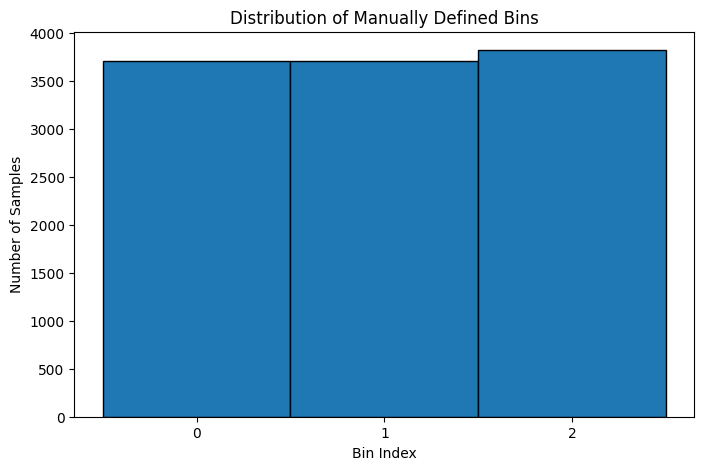

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of the binned data
plt.figure(figsize=(8, 5))
plt.hist(y_binned, bins=np.arange(num_bins + 1) - 0.5, edgecolor='black')
plt.title('Distribution of Manually Defined Bins')
plt.xlabel('Bin Index')
plt.ylabel('Number of Samples')
plt.xticks(range(num_bins))
plt.show()


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add a batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]  # Broadcast along the batch size
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, seq_length, num_bins):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_length)

        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)

        # Adjust the final output layer to predict bins
        self.fc_out = nn.Linear(d_model * seq_length, num_bins)

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)

        # Flatten the output from transformer encoder to feed into the final linear layer
        output = output.view(output.size(0), -1)
        output = self.fc_out(output).float()  # Keep as raw logits
        return output


In [ ]:
# Define model parameters
input_dim = X_tensor.shape[2]  # Number of features
d_model = 64  # Dimension of the model
nhead = 16  # Number of attention heads
num_encoder_layers = 5  # Number of encoder layers
dim_feedforward = 64  # Dimension of the feedforward network
seq_length = X_tensor.shape[1]  # Sequence length
output_dim = num_bins  # Predicting a single value (percent change)

model = TransformerModel(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, seq_length, output_dim)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
epochs = 32
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Clear the gradients

        outputs = model(inputs)  # Forward pass

        # Ensure targets are 1D LongTensor and represent bin indices
        targets = targets.squeeze().long()

        loss = criterion(outputs, targets)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters
        running_loss += loss.item()  # Accumulate loss

    average_train_loss = running_loss / len(train_loader)
    print(f"[{epoch+1}/{epochs}, {average_train_loss:.4f}", end='')

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    average_val_loss = val_loss / len(val_loader)
    print(f", {average_val_loss:.4f}]")


[1/32, 1.1186, 1.0868]
[2/32, 1.0967, 1.0994]
[3/32, 1.0930, 1.0785]
[4/32, 1.0881, 1.0787]
[5/32, 1.0898, 1.0743]
[6/32, 1.0890, 1.0878]
[7/32, 1.0879, 1.0757]
[8/32, 1.0859, 1.0723]
[9/32, 1.0820, 1.0717]
[10/32, 1.0820, 1.0728]
[11/32, 1.0819, 1.0671]
[12/32, 1.0817, 1.0710]
[13/32, 1.0817, 1.0699]
[14/32, 1.0800, 1.0705]
[15/32, 1.0784, 1.0730]
[16/32, 1.0801, 1.0784]
[17/32, 1.0805, 1.0643]
[18/32, 1.0764, 1.0706]
[19/32, 1.0785, 1.0755]
[20/32, 1.0788, 1.0737]
[21/32, 1.0786, 1.0771]
[22/32, 1.0778, 1.0685]
[23/32, 1.0792, 1.0741]
[24/32, 1.0763, 1.0660]
[25/32, 1.0778, 1.0675]
[26/32, 1.0756, 1.0722]
[27/32, 1.0773, 1.0803]
[28/32, 1.0766, 1.0789]
[29/32, 1.0774, 1.0741]
[30/32, 1.0760, 1.0763]
[31/32, 1.0763, 1.0706]
[32/32, 1.0763, 1.0649]


In [ ]:
def evaluate_model(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)  # Forward pass

            # Convert logits to predicted bin indices
            predicted_bins = torch.argmax(outputs, dim=1)

            # Ensure targets are properly squeezed to match the shape [batch_size]
            targets = targets.squeeze().long()

            # Calculate the loss
            loss = criterion(outputs, targets)  # This expects outputs to be [batch_size, num_bins] and targets [batch_size]
            total_loss += loss.item()

            # Collect targets and predictions for additional metrics
            all_targets.append(targets.numpy())
            all_predictions.append(predicted_bins.numpy())

    # Calculate average loss
    average_loss = total_loss / len(data_loader)

    # Flatten the lists for metric calculation
    all_targets = np.concatenate(all_targets, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    # Calculate additional metrics
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))

    return average_loss, mae, rmse, all_predictions, all_targets


In [ ]:
# Assuming 'test_loader' is your DataLoader for the test set
criterion = nn.CrossEntropyLoss()  # Use the same loss function as in training

# Evaluate the model
test_loss, test_mae, test_rmse, all_predictions, all_targets = evaluate_model(model, test_loader, criterion)

print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Test Loss (MSE): 1.0907
Test MAE: 0.8268
Test RMSE: 1.1144


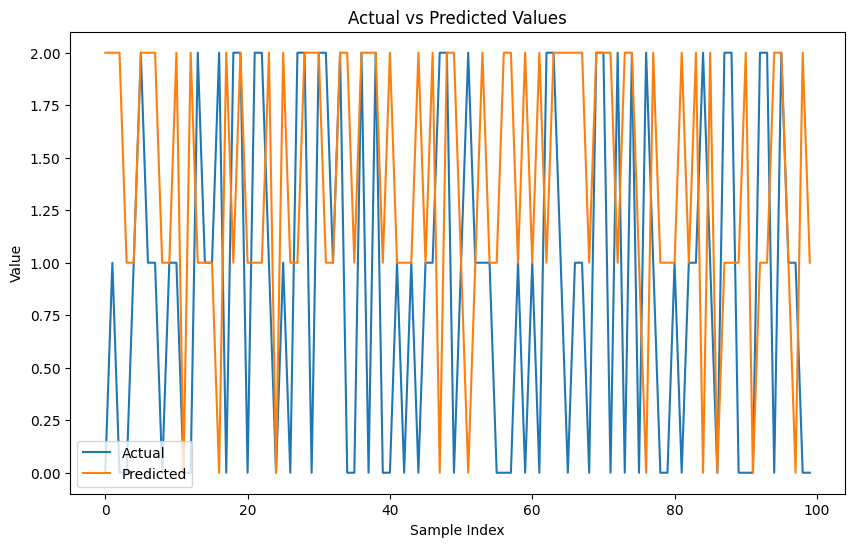

In [ ]:
# Plot the first batch of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(all_targets[:100], label='Actual')
plt.plot(all_predictions[:100], label='Predicted')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.show()


Test Loss: 1.0907
Test MAE: 0.8268
Test RMSE: 1.1144
Test Accuracy: 0.3808


<Figure size 1000x800 with 0 Axes>

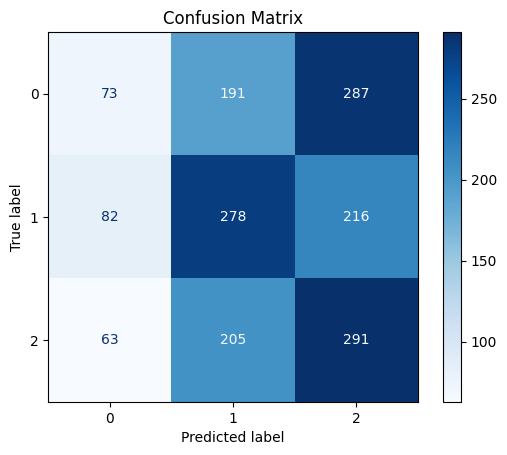

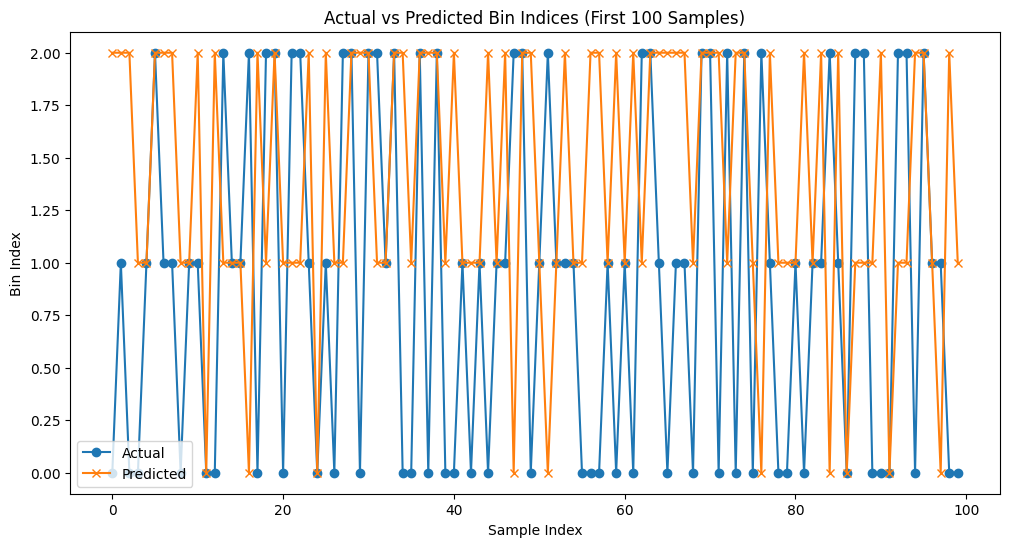

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

def evaluate_model(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)  # Forward pass

            # Convert logits to predicted bin indices
            predicted_bins = torch.argmax(outputs, dim=1)

            # Ensure targets are properly squeezed to match the shape [batch_size]
            targets = targets.squeeze().long()

            # Calculate the loss
            loss = criterion(outputs, targets)  # This expects outputs to be [batch_size, num_bins] and targets [batch_size]
            total_loss += loss.item()

            # Collect targets and predictions for additional metrics
            all_targets.append(targets.numpy())
            all_predictions.append(predicted_bins.numpy())

    # Calculate average loss
    average_loss = total_loss / len(data_loader)

    # Flatten the lists for metric calculation
    all_targets = np.concatenate(all_targets, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    # Calculate additional metrics
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    accuracy = accuracy_score(all_targets, all_predictions)
    conf_matrix = confusion_matrix(all_targets, all_predictions)

    return average_loss, mae, rmse, accuracy, conf_matrix, all_predictions, all_targets

# Assuming 'test_loader' is your DataLoader for the test set
criterion = nn.CrossEntropyLoss()  # Use the same loss function as in training

# Evaluate the model
test_loss, test_mae, test_rmse, test_accuracy, conf_matrix, all_predictions, all_targets = evaluate_model(model, test_loader, criterion)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(conf_matrix).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Plot the first batch of predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(all_targets[:100], label='Actual', marker='o')
plt.plot(all_predictions[:100], label='Predicted', marker='x')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Bin Index')
plt.title('Actual vs Predicted Bin Indices (First 100 Samples)')
plt.show()
